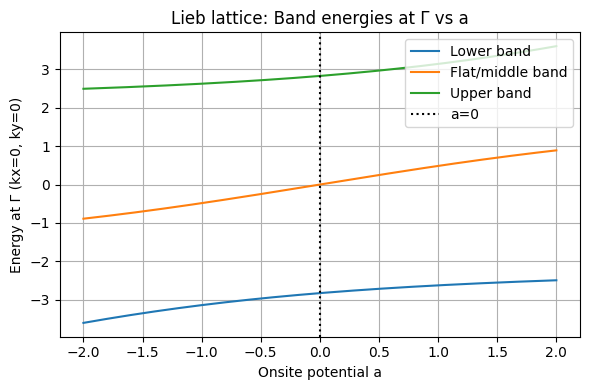

a = -1.0: energies = [-3.14133612 -0.48486195  2.62619807]
a = 0.0: energies = [-2.82842712  0.          2.82842712]
a = 1.0: energies = [-2.62619807  0.48486195  3.14133612]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh

#Lieb lattice Hamiltonian 
def H_lieb(kx, ky, kx_hop=1.0, ky_hop=1.0, a=0.0):
    """
    Lieb lattice Hamiltonian:
        H = [[0, 2*ky_hop*cos(ky), 2*kx_hop*cos(kx)],
             [2*ky_hop*cos(ky), a, 0],
             [2*kx_hop*cos(kx), 0, 0]]
    'a' breaks sublattice symmetry at the B site.
    """
    return np.array([
        [0, 2*ky_hop*np.cos(ky), 2*kx_hop*np.cos(kx)],
        [2*ky_hop*np.cos(ky), a, 0],
        [2*kx_hop*np.cos(kx), 0, 0]
    ], dtype=float)

#Compute eigenvalues at Gamma (kx=0, ky=0) for a range of 'a'
def lieb_bands_at_gamma(a_vals, kx_hop=1.0, ky_hop=1.0):
    eigs = []
    for a in a_vals:
        H = H_lieb(0.0, 0.0, kx_hop, ky_hop, a)
        e, _ = eigh(H)
        eigs.append(e)
    return np.array(eigs)

a_vals = np.linspace(-2.0, 2.0, 201)
bands = lieb_bands_at_gamma(a_vals)

#Plot the band energies at Gamma
plt.figure(figsize=(6,4))
plt.plot(a_vals, bands[:,0], label='Lower band')
plt.plot(a_vals, bands[:,1], label='Flat/middle band')
plt.plot(a_vals, bands[:,2], label='Upper band')
plt.axvline(0, color='k', linestyle=':', label='a=0')
plt.xlabel("Onsite potential a")
plt.ylabel("Energy at Γ (kx=0, ky=0)")
plt.title("Lieb lattice: Band energies at Γ vs a")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Quick check output
for a in [-1.0, 0.0, 1.0]:
    H = H_lieb(0.0, 0.0, 1.0, 1.0, a)
    e = eigh(H)[0]
    print(f"a = {a}: energies = {e}")



C:\Users\zimme\AppData\Local\Temp\ipykernel_524\65188679.py:49: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp((E - mu)/T))


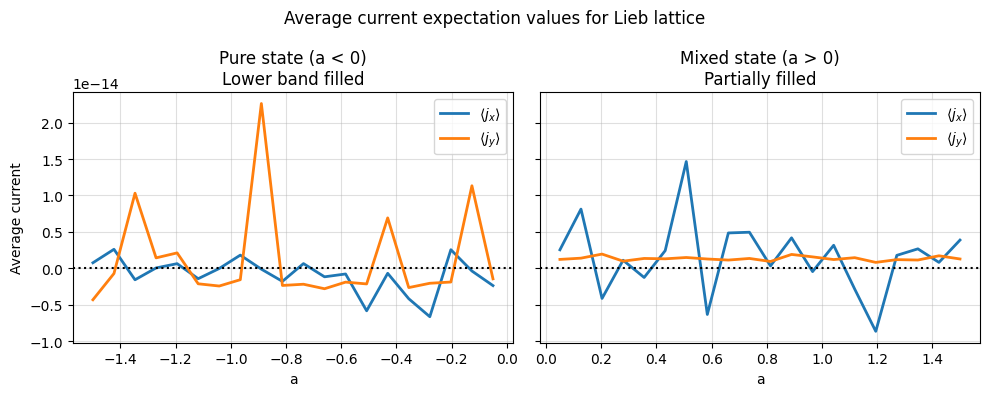

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh
from math import pi

#Lieb lattice Hamiltonian
def H_lieb(kx, ky, kx_hop=1.0, ky_hop=1.0, a=0.0):
    """
    Lieb lattice Hamiltonian:
    H = [[0, 2*ky_hop*cos(ky), 2*kx_hop*cos(kx)],
         [2*ky_hop*cos(ky), a, 0],
         [2*kx_hop*cos(kx), 0, 0]]
    'a' breaks sublattice symmetry at the middle site.
    """
    return np.array([
        [0, 2*ky_hop*np.cos(ky), 2*kx_hop*np.cos(kx)],
        [2*ky_hop*np.cos(ky), a, 0],
        [2*kx_hop*np.cos(kx), 0, 0]
    ], dtype=complex)

#Velocity operators (derivatives w.r.t kx, ky)
def dH_dkx(kx, ky, kx_hop=1.0):
    return np.array([
        [0, 0, -2*kx_hop*np.sin(kx)],
        [0, 0, 0],
        [-2*kx_hop*np.sin(kx), 0, 0]
    ], dtype=complex)

def dH_dky(kx, ky, ky_hop=1.0):
    return np.array([
        [0, -2*ky_hop*np.sin(ky), 0],
        [-2*ky_hop*np.sin(ky), 0, 0],
        [0, 0, 0]
    ], dtype=complex)

#Average current calculator
def average_currents(a, mu, T=0.05, nk=61):
    """
    Computes ⟨jx⟩, ⟨jy⟩ by integrating over the 2D Brillouin zone.
    mu: chemical potential
    T: temperature (small for pure state)
    nk: number of k-points in each direction
    """
    kx_vals = np.linspace(-pi, pi, nk)
    ky_vals = np.linspace(-pi, pi, nk)
    dk = (2*pi / nk)**2

    def fermi(E):
        return 1.0 / (1.0 + np.exp((E - mu)/T))

    Jx, Jy = 0.0, 0.0

    for kx in kx_vals:
        for ky in ky_vals:
            H = H_lieb(kx, ky, a=a)
            vx = dH_dkx(kx, ky)
            vy = dH_dky(kx, ky)
            E, U = eigh(H)
            for n in range(3):
                f = fermi(E[n])
                psi = U[:, n]
                Jx += f * np.real(np.conj(psi).T @ (vx @ psi)) * dk
                Jy += f * np.real(np.conj(psi).T @ (vy @ psi)) * dk
    return Jx, Jy

#Sweep over 'a' for pure (a<0) and mixed (a>0) states
a_pure = np.linspace(-1.5, -0.05, 20)   # pure state: lower band filled
a_mixed = np.linspace(0.05, 1.5, 20)    # mixed state: partial filling

Jx_pure, Jy_pure = [], []
Jx_mixed, Jy_mixed = [], []

#Pure state
T_pure = 0.001
for a in a_pure:
    #Chemical potential between lower and flat band
    E = np.sort(eigh(H_lieb(0, 0, a=a))[0])
    mu = 0.5*(E[0] + E[1])
    Jx, Jy = average_currents(a, mu, T=T_pure)
    Jx_pure.append(Jx)
    Jy_pure.append(Jy)

#Mixed state 
T_mixed = 0.1
for a in a_mixed:
    E = np.sort(eigh(H_lieb(0, 0, a=a))[0])
    mu = 0.5*(E[0] + E[1])
    Jx, Jy = average_currents(a, mu, T=T_mixed)
    Jx_mixed.append(Jx)
    Jy_mixed.append(Jy)

#Plot results
fig, axs = plt.subplots(1,2, figsize=(10,4), sharey=True)

#Pure state
axs[0].plot(a_pure, Jx_pure, label=r'$\langle j_x \rangle$', lw=2)
axs[0].plot(a_pure, Jy_pure, label=r'$\langle j_y \rangle$', lw=2)
axs[0].axhline(0, color='k', ls=':')
axs[0].set_title("Pure state (a < 0)\nLower band filled")
axs[0].set_xlabel("a")
axs[0].set_ylabel("Average current")
axs[0].legend()
axs[0].grid(True, alpha=0.4)

#Mixed state
axs[1].plot(a_mixed, Jx_mixed, label=r'$\langle j_x \rangle$', lw=2)
axs[1].plot(a_mixed, Jy_mixed, label=r'$\langle j_y \rangle$', lw=2)
axs[1].axhline(0, color='k', ls=':')
axs[1].set_title("Mixed state (a > 0)\nPartially filled")
axs[1].set_xlabel("a")
axs[1].legend()
axs[1].grid(True, alpha=0.4)

plt.suptitle("Average current expectation values for Lieb lattice")
plt.tight_layout()
plt.show()



C:\Users\zimme\AppData\Local\Temp\ipykernel_524\1136079569.py:39: RuntimeWarning: overflow encountered in exp
  return 1.0 / (1.0 + np.exp((E - mu)/T))


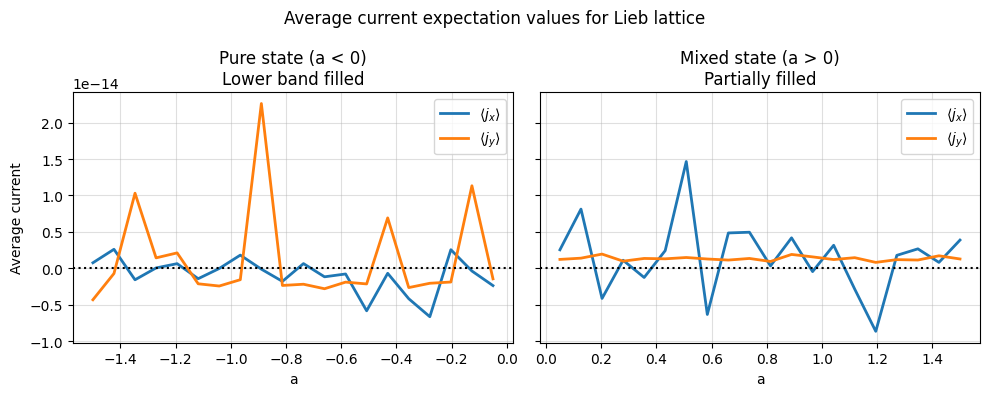

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import eigh
from math import pi

#Hamiltonian and velocity operators
def H_lieb(kx, ky, a=0.0):
    return np.array([
        [0, 2*np.cos(ky), 2*np.cos(kx)],
        [2*np.cos(ky), a, 0],
        [2*np.cos(kx), 0, 0]
    ], dtype=float)

def dH_dkx(kx, ky):
    return np.array([
        [0, 0, -2*np.sin(kx)],
        [0, 0, 0],
        [-2*np.sin(kx), 0, 0]
    ], dtype=complex)

def dH_dky(kx, ky):
    return np.array([
        [0, -2*np.sin(ky), 0],
        [-2*np.sin(ky), 0, 0],
        [0, 0, 0]
    ], dtype=complex)

#Average currents function
def average_currents(a, mu, T=0.05, nk=61):
    kx_vals = np.linspace(-pi, pi, nk)
    ky_vals = np.linspace(-pi, pi, nk)
    dk = (2*pi / nk)**2

    def fermi(E):
        return 1.0 / (1.0 + np.exp((E - mu)/T))

    Jx, Jy = 0.0, 0.0
    for kx in kx_vals:
        for ky in ky_vals:
            H = H_lieb(kx, ky, a=a)
            vx = dH_dkx(kx, ky)
            vy = dH_dky(kx, ky)
            E, U = eigh(H)
            for n in range(3):
                f = fermi(E[n])
                psi = U[:, n]
                Jx += f * np.real(np.conj(psi).T @ (vx @ psi)) * dk
                Jy += f * np.real(np.conj(psi).T @ (vy @ psi)) * dk
    return Jx, Jy

#Define a ranges for pure and mixed states
a_pure = np.linspace(-1.5, -0.05, 20)   # lower band filled
a_mixed = np.linspace(0.05, 1.5, 20)    # partially filled

Jx_pure, Jy_pure = [], []
Jx_mixed, Jy_mixed = [], []

#Pure state currents
T_pure = 0.001
for a in a_pure:
    E = np.sort(eigh(H_lieb(0,0,a=a))[0])
    mu = 0.5*(E[0] + E[1])   # chemical potential between lower and flat band
    Jx, Jy = average_currents(a, mu, T=T_pure)
    Jx_pure.append(Jx)
    Jy_pure.append(Jy)

#Mixed state currents
T_mixed = 0.1
for a in a_mixed:
    E = np.sort(eigh(H_lieb(0,0,a=a))[0])
    mu = 0.5*(E[0] + E[1])
    Jx, Jy = average_currents(a, mu, T=T_mixed)
    Jx_mixed.append(Jx)
    Jy_mixed.append(Jy)

#Plot currents
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

#Pure state
axs[0].plot(a_pure, Jx_pure, label=r'$\langle j_x \rangle$', lw=2)
axs[0].plot(a_pure, Jy_pure, label=r'$\langle j_y \rangle$', lw=2)
axs[0].axhline(0, color='k', linestyle=':')
axs[0].set_title("Pure state (a < 0)\nLower band filled")
axs[0].set_xlabel("a")
axs[0].set_ylabel("Average current")
axs[0].legend()
axs[0].grid(True, alpha=0.4)

#Mixed state
axs[1].plot(a_mixed, Jx_mixed, label=r'$\langle j_x \rangle$', lw=2)
axs[1].plot(a_mixed, Jy_mixed, label=r'$\langle j_y \rangle$', lw=2)
axs[1].axhline(0, color='k', linestyle=':')
axs[1].set_title("Mixed state (a > 0)\nPartially filled")
axs[1].set_xlabel("a")
axs[1].legend()
axs[1].grid(True, alpha=0.4)

plt.suptitle("Average current expectation values for Lieb lattice")
plt.tight_layout()
plt.show()

